In [1]:
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
from contextlib import contextmanager

def REFERENCE(solution, placeholder):
    return solution
@contextmanager
def REFBLOCK():
    yield

In [3]:
# Code based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if ax is None:
        ax = plt.gca()

    cm = confusion_matrix(y_true, y_pred)
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if title is None:
            title = "Normalized confusion matrix"
    elif title is None:
        title = 'Confusion matrix (without normalization)'

    img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(img, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set(xticks=tick_marks, yticks=tick_marks)
    ax.set_xticklabels(classes, rotation=0)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    ax.set(title=title, ylabel='True label', xlabel='Predicted label')
    ax.grid(False)

# Load and Preprocess the data

* Download the data file from https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
* Dataset source: https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)

In [4]:
column_names = 'checking_status duration credit_history purpose credit_amount savings_status employment installment_commitment personal_status other_parties residence_since property_magnitude age other_payment_plans housing existing_credits job num_dependents own_telephone foreign_worker actual'.split()
credit_data = pd.read_csv(
    "german.data",
    delimiter=' ', index_col=False,
    names=column_names)

credit_data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,actual
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [5]:
credit_data['actual'] = credit_data['actual'].map({1: "good", 2: "bad"})

In [6]:
# The "personal status" attribute encodes a few different quantities. Let's split them apart.
credit_data[['sex', 'marital_status']] = credit_data['personal_status'].map({
    'A91': "male : divorced/separated",
    'A92': "female : divorced/separated/married",
    'A93': "male : single",
    'A94': "male : married/widowed",
    'A95': "female : single",
}).str.split(" : ", expand=True)
credit_data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,actual,sex,marital_status
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A143,A152,2,A173,1,A192,A201,good,male,single
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A143,A152,1,A173,1,A191,A201,bad,female,divorced/separated/married
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A143,A152,1,A172,2,A191,A201,good,male,single
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A143,A153,1,A173,2,A191,A201,good,male,single
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A143,A153,2,A173,2,A191,A201,bad,male,single


# Classifying Credit Risk

How does credit history relate with current credit risk?

In [7]:
pd.crosstab(credit_data['credit_history'], credit_data['actual'], margins=True, normalize='index')

actual,bad,good
credit_history,,
A30,0.625000,0.375000
A31,0.571429,0.428571
A32,0.318868,0.681132
A33,0.318182,0.681818
A34,0.170648,0.829352
All,0.300000,0.700000


In [8]:
X = pd.get_dummies(credit_data[['checking_status', 'savings_status', 'credit_history', 'employment', 'job']], drop_first=True)
X.head()

,checking_status_A12,checking_status_A13,checking_status_A14,savings_status_A62,savings_status_A63,savings_status_A64,savings_status_A65,credit_history_A31,credit_history_A32,credit_history_A33,credit_history_A34,employment_A72,employment_A73,employment_A74,employment_A75,job_A172,job_A173,job_A174
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0
1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [9]:
y_true = (credit_data['actual'] == 'good').astype(int)

# Compute the "prevalence" (see https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Confusion_matrix)
total_population = len(credit_data)
total_positive = np.sum(y_true)
prevalence = total_positive / total_population
print("Fraction of 'good' customers in the dataset:", prevalence)

Fraction of 'good' customers in the dataset: 0.7


In lab we tried using a Linear Regression to make this score.

```
clf = LinearRegression().fit(X, y_true)
```

Logistic Regression uses the same kind of linear model to create a score, but it accounts for the fact that a difference of, say, plus or minus 1.0 in the score makes a bigger difference when the score is close to the decision boundary. Notice the following things about `LogisticRegression`:

* The interface is almost identical to `LinearRegression`, at least in the case of a binary classification (e.g., good vs bad credit).
* The `predict` function gives the classifier's single decision. If we want the *score*, we need to ask it for the `decision_function`.
* The `decision_function` is very much like `LinearRegression`'s `.predict`, but the score is defined such that positive scores correspond to a decision of "1" and negative scores to "0". This makes more sense when we extend to more than two classes.

In [10]:
clf = LogisticRegression(solver='lbfgs').fit(X, y_true)

In [11]:
predicted_score = clf.decision_function(X)
predicted_score.shape

(1000,)

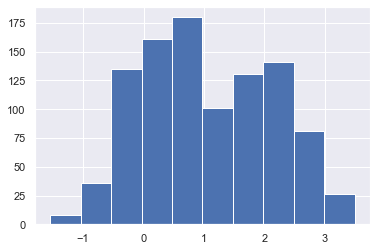

In [12]:
plt.hist(predicted_score);

Let's make a prediction by thresholding the score. First we'll try setting a threshold at 0. To summarize how this threshold does, we can plot the "confusion matrix". We'll use a function (defined up top) to make a nice plot.

First 5 predictions: [1 1 1 1 0]


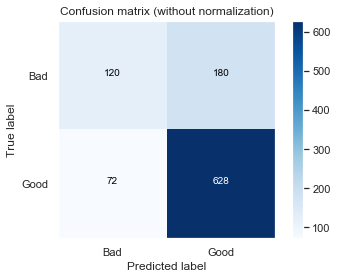

In [13]:
predicted = (predicted_score > 0.).astype(int)
print("First 5 predictions:", predicted[:5])
plot_confusion_matrix(y_true, predicted, classes=["Bad", "Good"])

## Exercise 1: Try a different threshold.
**Change the threshold so that all four boxes are non-zero**.

First 5 predictions: [0 0 1 0 0]


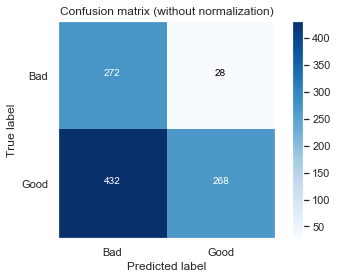

In [14]:
predicted = (predicted_score > REFERENCE(1.753, "0.")).astype(int)
print("First 5 predictions:", predicted[:5])
plot_confusion_matrix(y_true, predicted, classes=["Bad", "Good"])

## Exercise 2: Label false positives vs false negatives
Fill in the following cell with the counts corresponding to the threshold you chose in Exercise 1.

You may refer to the reading to clarify the definitions.

* True positives: **###**
* True negatives: **###**
* False positives: **###**
* False negatives: **###**

# Exercise 3: Write expressions to calculate FP/FN

Fill in the blanks in the following cell:

In [15]:
true_positives = np.sum((predicted == 1) & (y_true == 1))
true_negatives = np.sum((predicted == 0) & (y_true == 0))
false_positives = REFERENCE(np.sum((predicted == 1) & (y_true == 0)), "...")
false_negatives = REFERENCE(np.sum((predicted == 0) & (y_true == 1)), "...")

print("True positives:", true_positives)
print("True negatives:", true_negatives)
print("False positives:", false_positives)
print("False negatives:", false_negatives)

True positives: 268
True negatives: 272
False positives: 28
False negatives: 432


# Exercise 4: Compute derived quantities
Fill in the blanks in the following cell:

In [16]:
print("Precision:", ...)
print("Recall:", ...)
print("Positive rate:", ...)
print("True positive rate", ...)

Precision: Ellipsis
Recall: Ellipsis
Positive rate: Ellipsis
True positive rate Ellipsis


# Exercise 5: Calculate cost

According to the dataset description (see above), the bank assigned a cost of *5* to giving a loan to a "bad" customer (presumably because the customer defaulted on the loan) but a cost of only *1* to not giving a loan to a customer who actually would have been good (presumably because they would have paid the loan back with interest).

*Using your variables for `true_positive`, `true_negative`, `false_positive` and `false_negative`*, **fill in the blanks in the following cell** to *calculate* the cost to the bank associated with the threshold you chose. You may not need to use all four variables.

In [17]:
cost_to_bank = REFERENCE(5 * false_positives + 1 * false_negatives, "...")
avg_cost_per_person = cost_to_bank / total_population
print(f"Cost to bank is {cost_to_bank:.1f}, an average of {avg_cost_per_person:.2f} per person")

Cost to bank is 572.0, an average of 0.57 per person


# Exercise 6: Minimize cost (maximize profit)

1. Use your answers to the previous exercises to fill in the blanks in the code below that plots cost vs threshold.
2. Use that plot (and perhaps `results.sort_values`) to select a threshold value.
3. Go back to Exercise 1 and put this threshold value there.
4. Report the threshold value and its corresponding cost, positive rate, and true positive rate. (You can re-run the calculations above with your new threshold to get these numbers, but write them here for reference.)

In [18]:
# Note: this is a common pattern for collecting data into a Pandas DataFrame.
results = []
for threshold in np.linspace(np.min(predicted_score), np.max(predicted_score), 100):
    predicted = (predicted_score > threshold).astype(int)
    
    with REFBLOCK():
        false_positives = np.sum((predicted == 1) & (y_true == 0))
        false_negatives = np.sum((predicted == 0) & (y_true == 1))
        cost_to_bank = 5 * false_positives + 1 * false_negatives
        avg_cost_per_person = cost_to_bank / total_population

    results.append({
        "threshold": threshold,
        "avg_cost": avg_cost_per_person
    })
results = pd.DataFrame(results)

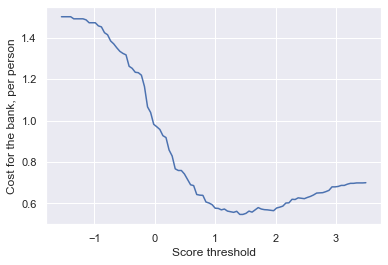

In [19]:
# It's almost always a good idea to separate the code that *makes a plot* from the code that *generates the data*. 
plt.plot(results.threshold, results.avg_cost)
plt.xlabel("Score threshold")
plt.ylabel("Cost for the bank, per person");

In [20]:
with REFBLOCK():
    display(results.sort_values('avg_cost').iloc[0])

avg_cost     0.547000
threshold    1.458961
Name: 59, dtype: float64

In [21]:
threshold = REFERENCE(1.458961, "...")
predicted = (predicted_score > threshold).astype(int)
with REFBLOCK():
    false_positives = np.sum((predicted == 1) & (y_true == 0))
    false_negatives = np.sum((predicted == 0) & (y_true == 1))
    cost = 5 * false_positives + 1 * false_negatives

    positive_rate = np.sum(predicted == 1) / total_population
    true_positives = np.sum((predicted == 1) & (y_true == 1))
    true_positive_rate = true_positives / total_population

print("My selected threshold was", threshold)
print("At that threshold, the cost to the bank is", cost)
print("... the positive rate is", positive_rate)
print("... and the true positive rate is", true_positive_rate)


My selected threshold was 1.458961
At that threshold, the cost to the bank is 547
... the positive rate is 0.381
... and the true positive rate is 0.343


# Exercise 7: Evaluating Ageism

The [Equal Credit Opportunity Act (ECOA)](https://www.consumer.ftc.gov/articles/0347-your-equal-credit-opportunity-rights) protects against lending discrimination on the basis of age. The Treasury Dept's [summary](https://www.occ.treas.gov/topics/consumers-and-communities/consumer-protection/fair-lending/index-fair-lending.html) says that "A lender's policies, *even when applied equally to all its credit applicants*, may have a negative effect on certain applicants." (emphasis mine.)

Even though our classifier does not consider age as a factor in making a decision, it is possible that it has *disparate impact* depending on an individual's age.

**Fill in the blanks in the following cell** to evaluate the classifier *that uses the threshold you chose above*.

In [22]:
credit_data['age_bin'] = np.where(credit_data['age'] >= 25, ">= 25", "< 25")

In [23]:
threshold = REFERENCE(1.458961, "...")
predicted = (predicted_score > threshold).astype(int)

age = credit_data['age_bin']
num_young = np.sum(age == '< 25')
num_old = np.sum(age == '>= 25')
print(f"{num_young} young, {num_old} old")

true_positives_young = np.sum((predicted == 1) & (y_true == 1) & (age == '< 25'))
true_positives_old = np.sum((predicted == 1) & (y_true == 1) & (age == '>= 25'))

positive_rate_young = REFERENCE(np.sum((predicted == 1) & (age == '< 25')) / num_young, "...")
positive_rate_old = REFERENCE(np.sum((predicted == 1) & (age == '>= 25')) / num_old, "...")

true_positive_rate_young = REFERENCE(true_positives_young / num_young, "...")
true_positive_rate_old = REFERENCE(true_positives_old / num_old, "...")

print(f"The positive rate is {positive_rate_young:.2f} for young and {positive_rate_old:.2f} for old")
print(f"The true positive rate is {true_positive_rate_young:.2f} for young and {true_positive_rate_old:.2f} for old")

149 young, 851 old
The positive rate is 0.23 for young and 0.41 for old
The true positive rate is 0.18 for young and 0.37 for old


# Exercise 8
1. Does this classifier exhibit **demographic parity**? Explain.
2. Does this classifier exhibit **equal opportunity** (considering "good" as the "favorable" class)? Explain.

Refer to the readings to remind yourself of the definitions of these terms.

1. *Your answer here*
2. *Your answer here*

Fill in the blanks in the following cell to make plots by age.

In [24]:
results_age = []
for threshold in np.linspace(np.min(predicted_score), np.max(predicted_score), 100):
    predicted = (predicted_score > threshold).astype(int)
    
    for cur_age in ['< 25', '>= 25']:
        num_of_this_age = np.sum(age == cur_age)
        true_positives_age = np.sum((predicted == 1) & (y_true == 1) & (age == cur_age))

        with REFBLOCK():
            false_positives_age = np.sum((predicted == 1) & (y_true == 0) & (age == cur_age))
            false_negatives_age = np.sum((predicted == 0) & (y_true == 1) & (age == cur_age))
            positives_age = np.sum((predicted == 1) & (age == cur_age))
            cost_age = 5 * false_positives_age + 1 * false_negatives_age

        results_age.append({
            "age": cur_age,
            "threshold": threshold,
            "avg_cost": cost_age / num_of_this_age,
            "positive_rate": REFERENCE(positives_age / num_of_this_age, '...'),
            "true_positive_rate": REFERENCE(true_positives_age / num_of_this_age, '...')
        })
results_age = pd.DataFrame(results_age)
results_age.head()

,age,avg_cost,positive_rate,threshold,true_positive_rate
0,< 25,2.046980,1.000000,-1.542171,0.590604
1,>= 25,1.405405,0.998825,-1.542171,0.717979
2,< 25,2.046980,1.000000,-1.491304,0.590604
3,>= 25,1.405405,0.998825,-1.491304,0.717979
4,< 25,2.046980,1.000000,-1.440438,0.590604


In [25]:
results_age_tidy = pd.melt(results_age, id_vars=['threshold', 'age'], var_name="measure")
results_age_tidy.head()

,threshold,age,measure,value
0,-1.542171,< 25,avg_cost,2.046980
1,-1.542171,>= 25,avg_cost,1.405405
2,-1.491304,< 25,avg_cost,2.046980
3,-1.491304,>= 25,avg_cost,1.405405
4,-1.440438,< 25,avg_cost,2.046980


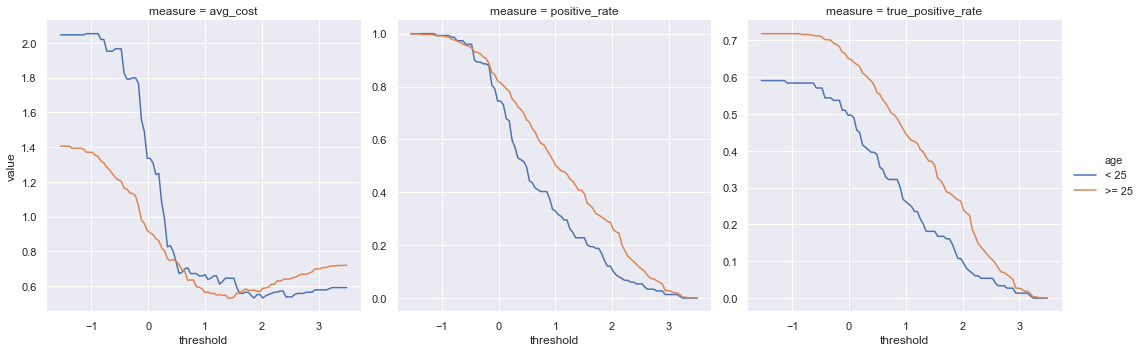

In [26]:
sns.relplot(
    x="threshold", y="value", hue="age",
    col="measure", facet_kws={'sharey': False},
    kind='line',
    data=results_age_tidy
)

# Exercise 9: Making a fairer classifier (maybe)
Pick one of "demographic parity" or "equal opportunity".

Use the charts above to select **two different thresholds**, one for each age group, that lead to a fairer classification by that metric. Fill in the code below to evaluate the fairness of your classifier as well as its cost to the bank.

In [27]:
threshold_young = REFERENCE(1.0, "...")
threshold_old = REFERENCE(2.0, "...")
predicted = (predicted_score > np.where(age == ">= 25", threshold_old, threshold_young)).astype(int)

age = credit_data['age_bin']
num_young = np.sum(age == '< 25')
num_old = np.sum(age == '>= 25')
print(f"{num_young} young, {num_old} old")

true_positives_young = np.sum((predicted == 1) & (y_true == 1) & (age == '< 25'))
true_positives_old = np.sum((predicted == 1) & (y_true == 1) & (age == '>= 25'))

positive_rate_young = REFERENCE(np.sum((predicted == 1) & (age == '< 25')) / num_young, "...")
positive_rate_old = REFERENCE(np.sum((predicted == 1) & (age == '>= 25')) / num_old, "...")

true_positive_rate_young = REFERENCE(true_positives_young / num_young, "...")
true_positive_rate_old = REFERENCE(true_positives_old / num_old, "...")

with REFBLOCK():
    false_positives = np.sum((predicted == 1) & (y_true == 0))
    false_negatives = np.sum((predicted == 0) & (y_true == 1))
    cost_to_bank = 5 * false_positives + 1 * false_negatives
    avg_cost_per_person = cost_to_bank / total_population

print(f"The average cost per person is {avg_cost_per_person:.2f}")
print(f"The positive rate is {positive_rate_young:.2f} for young and {positive_rate_old:.2f} for old")
print(f"The true positive rate is {true_positive_rate_young:.2f} for young and {true_positive_rate_old:.2f} for old")

149 young, 851 old
The average cost per person is 0.59
The positive rate is 0.33 for young and 0.27 for old
The true positive rate is 0.26 for young and 0.25 for old


# Exercise 10: Reflection

1. Does your new classifier exhibit **demographic parity**? Explain.
2. Does your new classifier exhibit **equal opportunity** (considering "good" as the "favorable" class)? Explain.
3. Suppose you were going to recommend that the bank use a specific classifier. (a) How would you *choose the thresholds* for this classifier? (b) How would you *argue to the bank* that your choice of thresholds is *good*, in light of considerations of cost (profit) and fairness?

1. *your answer here*
2. *your answer here*
3. 
    1. *your answer here*
    2. *your answer here*